In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import data_cleaning as dc
import plotting as plot
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
d1 = {a: a for a in xrange(24)}
d2 = {a: a-1 for a in xrange(25, 113)}
correction_mapping = dict(d1.items()+d2.items())

In [3]:
# Get players dataframe, this gives me all hero picks
# Filling NaNs with 0 makes perfect sense here
# All NaNs basically say that a player did not commit a certain action
players_df = pd.read_csv('dota-2-matches/players.csv').fillna(0)
# Get hero names, which allows me to parse nice names for my hero selection dataframe
heros_chart = pd.read_csv('dota-2-matches/heros_chart_corrected.csv')
# Get match info, mainly used for getting target labels for now
games_df = pd.read_csv('dota-2-matches/match.csv')

In [4]:
# Has all information on player slots and end game statistics
# Not super useful since I am limiting my observation to the first 10 minutes of the game
# Good for checking what hero each player picked
players_df.head(10)

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,assists,denies,last_hits,stuns,hero_damage,hero_healing,tower_damage,item_0,item_1,item_2,item_3,item_4,item_5,level,leaver_status,xp_hero,xp_creep,xp_roshan,xp_other,gold_other,gold_death,gold_buyback,gold_abandon,gold_sell,gold_destroying_structure,gold_killing_heros,gold_killing_creeps,gold_killing_roshan,gold_killing_couriers,unit_order_none,unit_order_move_to_position,unit_order_move_to_target,unit_order_attack_move,unit_order_attack_target,unit_order_cast_position,unit_order_cast_target,unit_order_cast_target_tree,unit_order_cast_no_target,unit_order_cast_toggle,unit_order_hold_position,unit_order_train_ability,unit_order_drop_item,unit_order_give_item,unit_order_pickup_item,unit_order_pickup_rune,unit_order_purchase_item,unit_order_sell_item,unit_order_disassemble_item,unit_order_move_item,unit_order_cast_toggle_auto,unit_order_stop,unit_order_taunt,unit_order_buyback,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,85,0,3261,10960,347,362,9,3,18,1,30,76.7356,8690,218,143,180,37,73,56,108,0,16,0,8840.0,5440.0,0.0,83.0,50.0,-957.0,0.0,0.0,212.0,3120.0,5145.0,1087.0,400.0,0.0,0.0,4070.0,1.0,25.0,416.0,51.0,144.0,3.0,71.0,0.0,188.0,16.0,0.0,0.0,0.0,2.0,35.0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,50,1,2954,17760,494,659,13,3,18,9,109,87.4164,23747,0,423,46,63,119,102,24,108,22,0,14331.0,8440.0,2683.0,671.0,395.0,-1137.0,0.0,0.0,1650.0,3299.0,6676.0,4317.0,937.0,0.0,0.0,5894.0,214.0,165.0,1031.0,98.0,39.0,4.0,439.0,0.0,346.0,22.0,0.0,0.0,12.0,52.0,30.0,4.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,82,2,110,12195,350,385,0,4,15,1,58,None,4217,1595,399,48,60,59,108,65,0,17,0,6692.0,8112.0,0.0,453.0,259.0,-1436.0,-1015.0,0.0,0.0,3142.0,2418.0,3697.0,400.0,0.0,0.0,7053.0,3.0,132.0,645.0,36.0,160.0,20.0,373.0,0.0,643.0,17.0,5.0,0.0,7.0,8.0,28.0,0.0,1.0,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,11,3,1179,22505,599,605,8,4,19,6,271,None,14832,2714,6055,63,147,154,164,79,160,21,0,8583.0,14230.0,894.0,293.0,100.0,-2156.0,0.0,0.0,938.0,4714.0,4104.0,10432.0,400.0,0.0,0.0,4712.0,133.0,163.0,690.0,9.0,15.0,7.0,406.0,0.0,150.0,21.0,0.0,0.0,1.0,9.0,45.0,7.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3,66,4,3307,23825,613,762,20,3,17,13,245,None,33740,243,1833,114,92,147,0,137,63,24,0,15814.0,14325.0,0.0,62.0,0.0,-1437.0,-1056.0,0.0,4194.0,3217.0,7467.0,9220.0,400.0,0.0,0.0,3853.0,7.0,7.0,1173.0,31.0,84.0,8.0,198.0,0.0,111.0,23.0,1.0,0.0,0.0,2.0,44.0,6.0,0.0,13.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,4,105,128,476,12285,397,524,5,6,8,5,162,None,10725,0,112,145,73,149,48,212,0,19,0,8502.0,12259.0,0.0,1.0,0.0,-2394.0,-2240.0,0.0,200.0,320.0,5281.0,6193.0,0.0,0.0,0.0,6593.0,166.0,76.0,832.0,196.0,3.0,5.0,96.0,2.0,161.0,19.0,0.0,0.0,2.0,0.0,36.0,3.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,101,129,317,10355,303,369,4,13,5,2,107,None,15028,764,0,50,11,102,36,185,81,16,0,5201.0,9417.0,0.0,1.0,0.0,-3287.0,0.0,0.0,262.0,320.0,3396.0,4356.0,0.0,0.0,0.0,3325.0,63.0,100.0,609.0,13.0,173.0,14.0,168.0,0.0,118.0,16.0,0.0,0.0,1.0,1.0,43.0,3.0,0.0,13.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,5,45,130,2390,13395,452,517,4,8,6,31,208,None,10230,0,2438,41,63,36,147,168,21,19,0,6853.0,13396.0,0.0,244.0,107.0,-3682.0,0.0,0.0,242.0,695.0,4350.0,8797.0,0.0,0.0,0.0,13557.0,11.0,214.0,3386.0,122.0,0.0,3.0,506.0,0.0,491.0,18.0,2.0,3.0,18.0,18.0,30.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,110.0,0.0,0.0,0.0,0.0,0.0
8,0,0,7,131,475,5035,189,223,1,14,8,0,27,67.0277,4774,0,0,36,0,0,46,0,180,12,0,4798.0,4038.0,0.0,27.0,0.0,-3286.0,-39.0,0.0,0.0,320.0,2127.0,1089.0,0.0,0.0,0.0,2217.0,55.

In [5]:
# Hero name to hero id mapping
# Very useful later on
heros_chart.head(3)

,name,hero_id,localized_name
0,npc_dota_hero_antimage,1,Anti-Mage
1,npc_dota_hero_axe,2,Axe
2,npc_dota_hero_bane,3,Bane


In [6]:
# Game based information compiled at the end of each game
# My target variable (match outcome) will come from this DataFrame
games_df.head(3)

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132


In [4]:
players_df = dc.assign_player_team(players_df)
hero_selection_df = dc.construct_hero_selection_df(players_df, heros_chart)

In [8]:
# Selected heros are given 1, others 0
# 112 heros in total, 224 columns represetns 112 choices for each team (Radiant and Dire)
hero_selection_df.head()

,Anti-Mage_radiant,Axe_radiant,Bane_radiant,Bloodseeker_radiant,Crystal_Maiden_radiant,Drow_Ranger_radiant,Earthshaker_radiant,Juggernaut_radiant,Mirana_radiant,Morphling_radiant,Shadow_Fiend_radiant,Phantom_Lancer_radiant,Puck_radiant,Pudge_radiant,Razor_radiant,Sand_King_radiant,Storm_Spirit_radiant,Sven_radiant,Tiny_radiant,Vengeful_Spirit_radiant,Windranger_radiant,Zeus_radiant,Kunkka_radiant,Lina_radiant,Lion_radiant,Shadow_Shaman_radiant,Slardar_radiant,Tidehunter_radiant,Witch_Doctor_radiant,Lich_radiant,Riki_radiant,Enigma_radiant,Tinker_radiant,Sniper_radiant,Necrophos_radiant,Warlock_radiant,Beastmaster_radiant,Queen_of_Pain_radiant,Venomancer_radiant,Faceless_Void_radiant,Wraith_King_radiant,Death_Prophet_radiant,Phantom_Assassin_radiant,Pugna_radiant,Templar_Assassin_radiant,Viper_radiant,Luna_radiant,Dragon_Knight_radiant,Dazzle_radiant,Clockwerk_radiant,Leshrac_radiant,Nature's_Prophet_radiant,Lifestealer_radiant,Dark_Seer_radiant,Clinkz_radiant,Omniknight_radiant,Enchantress_radiant,Huskar_radiant,Night_Stalker_radiant,Broodmother_radiant,Bounty_Hunter_radiant,Weaver_radiant,Jakiro_radiant,Batrider_radiant,Chen_radiant,Spectre_radiant,Ancient_Apparition_radiant,Doom_radiant,Ursa_radiant,Spirit_Breaker_radiant,Gyrocopter_radiant,Alchemist_radiant,Invoker_radiant,Silencer_radiant,Outworld_Devourer_radiant,Lycan_radiant,Brewmaster_radiant,Shadow_Demon_radiant,Lone_Druid_radiant,Chaos_Knight_radiant,Meepo_radiant,Treant_Protector_radiant,Ogre_Magi_radiant,Undying_radiant,Rubick_radiant,Disruptor_radiant,Nyx_Assassin_radiant,Naga_Siren_radiant,Keeper_of_the_Light_radiant,Io_radiant,Visage_radiant,Slark_radiant,Medusa_radiant,Troll_Warlord_radiant,Centaur_Warrunner_radiant,Magnus_radiant,Timbersaw_radiant,Bristleback_radiant,Tusk_radiant,Skywrath_Mage_radiant,Abaddon_radiant,Elder_Titan_radiant,Legion_Commander_radiant,Techies_radiant,Ember_Spirit_radiant,Earth_Spirit_radiant,Underlord_radiant,Terrorblade_radiant,Phoenix_radiant,Oracle_radiant,Winter_Wyvern_radiant,Arc_Warden_radiant,Anti-Mage_dire,Axe_dire,Bane_dire,Bloodseeker_dire,Crystal_Maiden_dire,Drow_Ranger_dire,Earthshaker_dire,Juggernaut_dire,Mirana_dire,Morphling_dire,Shadow_Fiend_dire,Phantom_Lancer_dire,Puck_dire,Pudge_dire,Razor_dire,Sand_King_dire,Storm_Spirit_dire,Sven_dire,Tiny_dire,Vengeful_Spirit_dire,Windranger_dire,Zeus_dire,Kunkka_dire,Lina_dire,Lion_dire,Shadow_Shaman_dire,Slardar_dire,Tidehunter_dire,Witch_Doctor_dire,Lich_dire,Riki_dire,Enigma_dire,Tinker_dire,Sniper_dire,Necrophos_dire,Warlock_dire,Beastmaster_dire,Queen_of_Pain_dire,Venomancer_dire,Faceless_Void_dire,Wraith_King_dire,Death_Prophet_dire,Phantom_Assassin_dire,Pugna_dire,Templar_Assassin_dire,Viper_dire,Luna_dire,Dragon_Knight_dire,Dazzle_dire,Clockwerk_dire,Leshrac_dire,Nature's_Prophet_dire,Lifestealer_dire,Dark_Seer_dire,Clinkz_dire,Omniknight_dire,Enchantress_dire,Huskar_dire,Night_Stalker_dire,Broodmother_dire,Bounty_Hunter_dire,Weaver_dire,Jakiro_dire,Batrider_dire,Chen_dire,Spectre_dire,Ancient_Apparition_dire,Doom_dire,Ursa_dire,Spirit_Breaker_dire,Gyrocopter_dire,Alchemist_dire,Invoker_dire,Silencer_dire,Outworld_Devourer_dire,Lycan_dire,Brewmaster_dire,Shadow_Demon_dire,Lone_Druid_dire,Chaos_Knight_dire,Meepo_dire,Treant_Protector_dire,Ogre_Magi_dire,Undying_dire,Rubick_dire,Disruptor_dire,Nyx_Assassin_dire,Naga_Siren_dire,Keeper_of_the_Light_dire,Io_dire,Visage_dire,Slark_dire,Medusa_dire,Troll_Warlord_dire,Centaur_Warrunner_dire,Magnus_dire,Timbersaw_dire,Bristleback_dire,Tusk_dire,Skywrath_Mage_dire,Abaddon_dire,Elder_Titan_dire,Legion_Commander_dire,Techies_dire,Ember_Spirit_dire,Earth_Spirit_dire,Underlord_dire,Terrorblade_dire,Phoenix_dire,Oracle_dire,Winter_Wyvern_dire,Arc_Warden_dire
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [5]:
X = hero_selection_df.values
y = games_df.radiant_win.astype(int).values

# Base Models

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression
The Logisitic Regression Model performed better than I thought. The OG study performed 10% better, but then again it only used the ranked matches from the top 8% players. This is good news for me. I believe that the performance decrease is very much likely caused by the interaction between hero selections and other features within the game.

In [11]:
# Logistic Regression
lr = LogisticRegression()
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.596425026305


### Random Forest
I am surprised that the Random Forest Classifier did not perform as well as Logistic Regression, given RF's excellent track record with my case studies. However, given the my featuer construction, and the way DotA 2 is played, Random Forest can be the sub-optimal classifier when I only hero selection as my feature matrix.

In [12]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=150, criterion='entropy', n_jobs=-1)
print 'CV score for RF: ', cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for RF:  0.576475338433


### K-Nearest Neighbors
This, following the results from Logistic Regression, is somewhat expected. The OG study had KNN performing marginally better than the Logistic Regression. However, KNN is merely better than chance here. That, again, lends validity to interactions between hero selections and user/game features.

In [13]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_jobs=-1)
print 'CV score for KNN: ', cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for KNN:  0.526325181541


# Advanced Models
Allow me to preface this section by ditching KNN models for future testing. As I add more features beyond what I have so far, KNN will perform worse in prediction both time-wise and accuracy-wise. Adding features makes the distance calculation even harder. Moreover, any distanced based method is prone to the curse of dimensionality. Therefore, KNN seems like a less reasonable choice. You will not see any KNN beyond this section.

### 1st Engineered Feature(s): 10 minute benchmark for every player
I believe that, by cutting off my observation at the 10 minute benchmark, I am preventing leaks. My job is essentially predicting the outcome of the endgame by looking at the first 10 mintues within the game. This does not violate that condition I imposed upon my study. The benchmark consists of the max running gold, number of last hits and experience level before the 10-minute mark. Luckily these can all be calculated from a split-apply-max algorithm. The choice of max RUNNING average is intentional, as the gold amount recorded in player_time.csv is the the gold owned at the recorded time. However, early games involves lots of purchases. A higher max running gold amount implies that a player could potentially purchase better items within that time period. Using the gold exactly AT the 10-minute mark will not necessarily capture that information. Experience and number of last hits are non-decreasing, hence choosing their running max is equivalent to getting the 10-minute mark record.

In [6]:
# This dataframe gives gold, last hits, experience at 60 seconds intervals
players_time_df = pd.read_csv('dota-2-matches/player_time.csv')
players_time_df.head(10)

,match_id,times,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,xp_t_2,gold_t_3,lh_t_3,xp_t_3,gold_t_4,lh_t_4,xp_t_4,gold_t_128,lh_t_128,xp_t_128,gold_t_129,lh_t_129,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,60,409,0,63,142,1,186,168,0,125,200,0,193,194,1,125,174,2,77,138,1,62,345,6,351,100,0,77,613,1,125
2,0,120,546,0,283,622,4,645,330,0,376,345,1,698,628,5,374,354,4,437,673,5,543,684,12,805,200,0,210,815,5,323
3,0,180,683,1,314,927,9,1202,430,0,376,644,6,1172,806,7,570,614,8,829,895,8,842,958,16,1135,300,0,210,1290,8,527
4,0,240,956,1,485,1264,11,1583,530,0,391,919,11,1610,1281,10,1216,1082,8,1318,1087,10,1048,1500,26,1842,400,0,210,1431,9,589
5,0,300,1056,1,649,1451,13,1810,630,0,504,1102,15,1888,1708,17,1633,1300,11,1901,1233,11,1352,1841,32,2162,500,0,241,2110,17,918
6,0,360,1156,1,680,1744,18,2192,730,0,535,1326,18,2197,2339,21,2203,1520,14,2231,1497,15,1806,2186,38,2554,600,0,241,2623,28,1248
7,0,420,1257,2,778,2053,23,2584,830,0,566,1711,25,2558,2693,27,2574,1620,14,2231,1761,19,2033,2652,47,3111,700,0,241,3033,28,1329
8,0,480,1809,3,1135,2536,32,3153,1328,0,1144,2075,32,3161,3269,31,3046,1720,14,2384,2126,25,2575,3196,57,3715,858,1,300,3380,32,1535
9,0,540,2111,3,1393,3033,33,3449,1510,1,1306,2386,39,3398,3606,36,3361,2194,22,2905,2306,27,2967,3629,65,4169,958,1,300,3648,34,1697


In [7]:
# Construct the time bracket data, which cuts off everything after the time threshold
ten_min_player_df = dc.construct_x_seconds_df(players_time_df, threshold=600)
# Save the dataframe for future use, also saves memory usage
# ten_min_player_df.to_csv('dota-2-matches/ten_min_player_time.csv', index=False)
# Construct the player info exactly at the 10 minute mark
ten_min_max_wealth = dc.construct_x_seconds_max_wealth(ten_min_player_df)
# Combine that info with my hero_selection_df
first_adv_feature_mat = hero_selection_df.join(ten_min_max_wealth)
ten_min_max_wealth.head()

,gold_t_0,lh_t_0,xp_t_0,gold_t_1,lh_t_1,xp_t_1,gold_t_2,lh_t_2,xp_t_2,gold_t_3,lh_t_3,xp_t_3,gold_t_4,lh_t_4,xp_t_4,gold_t_128,lh_t_128,xp_t_128,gold_t_129,lh_t_129,xp_t_129,gold_t_130,lh_t_130,xp_t_130,gold_t_131,lh_t_131,xp_t_131,gold_t_132,lh_t_132,xp_t_132
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2211,3,1532,3379,39,3903,1650,2,1450,2859,51,4017,3745,37,3464,2623,30,3395,2573,31,3295,3853,68,4396,1058,1,315,4164,41,2124
1,1560,4,1393,3749,57,4065,2453,12,1774,2811,25,2207,3748,42,4364,5015,44,4095,3286,20,3182,1741,2,2035,2869,27,3085,2991,35,3320
2,2561,17,2460,2380,23,3033,2869,24,3230,2033,23,2172,1044,2,1560,3448,32,3088,1992,4,2529,3559,41,4642,1974,4,1786,1120,3,1524
3,1745,7,2100,2780,29,1935,1741,16,2781,1839,10,1848,2689,24,3721,1619,13,1539,2820,25,3590,1136,3,1947,1178,3,1367,4242,63,3676
4,4108,66,3802,4735,39,4778,2339,30,2365,1525,3,1723,2871,44,2534,1410,6,1685,1826,11,1752,2990,18,2778,3428,49,3108,1781,17,1783


In [8]:
X = first_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression
Logistic regression benefitted quite a bit from the addition of 10-minute benchmarks of every player. It goes to show that even the first ten minutes of a game can be quite telling about the outcome of a game. While I try to fit the same feature matrix with a random forest classifier, I would check for other information that can be extracted from the first 10 minutes.

In [49]:
# Logistic Regression
lr = LogisticRegression()
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.68532535237


### Random Forest
Again, random forest performed worse than logistic regression. The addition of time info does not capture all interactions between player skills and hero selection. I believe that since each component contribute somewhat equally to the match outcome, splitting on a single feature will not offer much information gain about how a match will turn out. Moreover, RF randomly subsets features at each split, which forces the model to look at a smaller information space that will not be very telling of the game outcome. One way to address this is to eliminate the need for subsetting features (basically a bagged forest), so that all features are considered at all times. However, given the time it takes to train a random Forest is faily long, I will save that for GridSearch.

In [18]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=150, criterion='entropy', n_jobs=-1)
print 'CV score for RF: ', cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for RF:  0.653500595191


### 2nd Engineered Feature(s): 10 minute gold growth benchmarks
My motivation for investigating gold growth is two-fold. First, the first 10 minutes of the game was actually richer than I thought. I want to investigate information provided within this timeframe even more. Second, the max is a point estimate. It is not necessarily representative of the flow of information. Hence I am calcualting the mean and standard deviation of gold growth (calculated on a minute-to-minute basis) for each player within the first 10 minutes. The point gold calculation will be normalized by -100gold/min, since this is the gold growth even if a player stays idle. Mean and standard deviation will be calculated after the normalization.

In [50]:
# Construct the gold growth benchmark within the first 10 minutes of the game for every player
# The gold_growth_benchmark contains both mean and standard deviation of gold growths
gold_growth_benchmark = dc.construct_x_seconds_gold_growth_benchmark(ten_min_player_df)
# Combine the info with the first advanced feature matrix from above
second_adv_feature_mat = hero_selection_df.join(gold_growth_benchmark)
gold_growth_benchmark.head()

,gold_t_0_mean,gold_t_1_mean,gold_t_2_mean,gold_t_3_mean,gold_t_4_mean,gold_t_128_mean,gold_t_129_mean,gold_t_130_mean,gold_t_131_mean,gold_t_132_mean,gold_t_0_std,gold_t_1_std,gold_t_2_std,gold_t_3_std,gold_t_4_std,gold_t_128_std,gold_t_129_std,gold_t_130_std,gold_t_131_std,gold_t_132_std
match_id,,,,,,,,,,,,,,,,,,,,
0,121.1,237.9,65.0,185.9,274.5,162.3,157.3,285.3,5.8,316.4,158.676785,120.971484,121.539203,101.925299,167.089630,143.731269,118.793051,107.645560,18.341210,176.064508
1,56.0,274.9,145.3,181.1,274.8,401.5,228.6,74.1,186.9,199.1,97.447422,134.166936,180.330591,156.033793,140.934027,221.193857,210.505846,137.329652,127.251675,130.630480
2,156.1,138.0,186.9,103.3,4.4,244.8,99.2,255.9,97.4,12.0,112.201654,117.777568,179.388127,76.151968,14.268847,163.145334,94.631214,148.751433,201.594312,19.567547
3,74.5,178.0,74.1,83.9,168.9,61.9,182.0,13.6,17.8,324.2,69.572105,194.666667,45.600804,100.630733,173.308620,70.224165,163.586878,21.899772,29.969614,129.039873
4,310.8,373.5,133.9,52.5,187.1,41.0,82.6,199.0,242.8,78.1,196.918934,191.483826,87.477553,125.488601,106.804546,70.329384,99.018741,223.275614,82.677150,46.841221


In [51]:
X = second_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Logistic Regression
I guess it should not come as a surprise that logistic regression failed to perform any better than before. The previous max_wealth dataframe, which contains the max gold, number of last hits and experience, has told most of the story already. It seems that there are not much to be gained from the new metrics, which deals mainly with gold growth for each player.

In [52]:
# Logistic Regression
lr = LogisticRegression()
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.686150017241


### 3rd Engineered Feature(s): net death counts from team fights before the 10-minute mark
The motivation for this feature is to attack information other than the amount of gold owned by each player within the first 10 minutes. For that I turn to teamfight information within the first 10 mintues. I want to get the death count for both radiant and dire before the 10 minute mark. Although death of an enemy player rewards the killer and nearby teammates with gold, death itself represents information about the interaction between teams, whose outcome does not rely solely on gold difference in early game.

In [23]:
# Deleted to save memory, also because second advanced feature matrix did not do well at all
del second_adv_feature_mat

In [43]:
team_fights_df = pd.read_csv('dota-2-matches/teamfights.csv')
num_team_fights_before_ten_min_df = dc.construct_num_team_fights(team_fights_df, threshold=600)
# Get the number of team fights before 10 minute mark for every match from above
# Get information on those team fights down here
teamfight_players_df = pd.read_csv('dota-2-matches/teamfights_players.csv')

In [44]:
net_death_count_before_ten_min_df = dc.construct_net_death_count_from_teamfights(teamfight_players_df, 
                                                                                 num_team_fights_before_ten_min_df)
third_adv_feature_mat = first_adv_feature_mat.join(net_death_count_before_ten_min_df)
net_death_count_before_ten_min_df.head()

,radiant_net_death_count,dire_net_death_count
0,1,8
1,13,11
2,10,9
3,10,9
4,2,6


In [45]:
X = third_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression
At this point, I believe my model's performance is being bottlenecked. Logistic regression performed more or less on the same level as what we did before. The informatin space of the first 10 minutes of every game is being exhausted, resulting in the meagre improvement in cross validation accuracy. If random forest fails to yield any huge improvement, it should corroborate this very claim.

In [46]:
# Logistic Regression
lr = LogisticRegression()
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.762750306948


### 4th Engineered Feature(s): Role Compositions
The motivation for this feature is simple. Every hero takes on different roles. If hero selection matters, then it should not just be about counters, but also how each hero operates throughout the game. Following this line of logic, I am going to first scrape the official DotA 2 website for hero roles and construct a hero attribute dataframe, then get the hero composition for each team in every game and see if my model gets higher accuracies.

### Part 1

In [29]:
# The hero index mapping is a dictionary that has hero name as keys and index as values
hero_index_mapping = dc.get_hero_index_mapping(heros_chart)
# Scrape the website for hero role information, and return a dictionary with hero names as keys and their list of roles as values
hero_roles = dc.construct_hero_roles(hero_index_mapping)
# Compile all possible roels as features, give each hero 1 for taking on a role, and 0 otherwise
hero_attribute_df = dc.construct_hero_attribute_df(hero_roles)
# For each team in every game, sum hero attributes for selected heros (hence max value in any team role is 5)
# Roles in considerations are: Carry, Support, Disabler, Initiator. The rest are dropped during construction.
hero_composition_df = dc.construct_hero_composition_df(players_df, hero_attribute_df)
# It makes sense to have interaction between carries and supports, so this cell handles that
# Gives two new columns, each representing the quantity of support per unit of carry
hero_composition_df['Carry_Support_radiant'] = hero_composition_df['Support_radiant'] / (hero_composition_df['Carry_radiant']+0.01)
hero_composition_df['Carry_Support_dire'] = hero_composition_df['Support_dire'] / (hero_composition_df['Carry_dire']+0.01)

fourth_adv_feature_mat = first_adv_feature_mat.join(hero_composition_df)

In [30]:
hero_attribute_df.head()

,Carry,Disabler,Initiator,Support
0,1,0,0,0
1,0,1,1,0
2,0,1,0,1
3,1,1,1,0
4,0,1,0,1


In [31]:
hero_composition_df.head()

,Carry_radiant,Disabler_radiant,Initiator_radiant,Support_radiant,Carry_dire,Disabler_dire,Initiator_dire,Support_dire,Carry_Support_radiant,Carry_Support_dire
0,2,4,2,4,3,4,3,0,1.990050,0.000000
1,2,3,2,2,3,5,2,1,0.995025,0.332226
2,4,5,3,3,3,2,1,1,0.748130,0.332226
3,0,4,4,2,3,4,3,2,200.000000,0.664452
4,3,4,2,2,2,3,1,3,0.664452,1.492537


In [32]:
X = fourth_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression
This is actually pretty disappointing. My Logistic Regression's performance is still bottlenecked. At this point, I believe that I am not using my domain knowledge of the game enough. DotA 2's official role assignment is not necessarily accurate. Almost every hero takes on more than 3 roles. The separation of duties is not as clear-cut as the model would like it to be. Moreover, I assigned 1 for simply taking on a role. However, in reality these each hero takes on roles with differing degrees. My current assignment fails to capture that. I will hard code a version of hero role information based on domain knowledge and a bit of research to address this issue in the second part.

In [33]:
# Logistic Regression
lr = LogisticRegression(penalty='l1', C=10)
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.687525


### Part 2

In [11]:
# This is the hardcoded version of hero_attribute_df based on domain knowledge and a bit of reasearch into each hero
# Every hero has its role values sum up to 1 (still, max value in a role for each team is 5)
# However we do have better handle on how deep into a role a hero is
hero_attribute_df = dc.construct_hard_coded_hero_attribute_df()
hero_composition_df = dc.construct_hero_composition_df(players_df, hero_attribute_df)
# Again, interaction terms are worth looking into
hero_composition_df['Carry_Support_radiant'] = hero_composition_df['Carry_radiant'] * hero_composition_df['Hard_Support_radiant']
hero_composition_df['Carry_Support_dire'] = hero_composition_df['Carry_dire'] * hero_composition_df['Hard_Support_dire']
fourth_adv_feature_mat = first_adv_feature_mat.join(hero_composition_df)

This attribute DataFrame is using the professional team composition. The hardcoded version of hero attribute has every row or hero's role sum up to 1. This is to enforce homogeneity across all heros. Each role a hero takes on also vary in magnitude, which addresses the problem I had in part 1.

In [36]:
hero_attribute_df.head()

,Carry,Mid,Offlane,Farm_Support,Hard_Support
0,1.0,0.0,0.00,0.00,0.00
1,0.0,0.0,0.55,0.45,0.00
2,0.0,0.0,0.30,0.00,0.70
3,0.2,0.1,0.15,0.55,0.00
4,0.0,0.0,0.35,0.00,0.65


In [37]:
hero_composition_df.head()

,Carry_radiant,Mid_radiant,Offlane_radiant,Farm_Support_radiant,Hard_Support_radiant,Carry_dire,Mid_dire,Offlane_dire,Farm_Support_dire,Hard_Support_dire,Carry_Support_radiant,Carry_Support_dire
0,1.05,0.7,1.15,0.00,2.10,1.05,1.75,1.45,0.0,0.75,2.2050,0.7875
1,1.60,0.9,1.30,0.10,1.10,0.95,1.95,0.95,0.0,1.15,1.7600,1.0925
2,1.75,0.6,1.95,0.25,0.45,1.80,1.80,0.70,0.0,0.70,0.7875,1.2600
3,0.00,0.3,1.85,1.00,1.85,1.35,0.30,1.85,0.0,1.50,0.0000,2.0250
4,0.90,0.8,2.20,0.20,0.90,0.45,1.40,1.45,0.0,1.70,0.8100,0.7650


In [38]:
X = fourth_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression

In [39]:
# Logistic Regression
lr = LogisticRegression(penalty='l1', C=10)
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.688500102358


### Extra: Firstblood status
I am only looking at first kills that takes place within the first 10 minutes. In pro scenes, first bloods usually do not carry much implications. In lower brackets, however, a first kill can affect players' mood and can possibly affect the outcome of the game. This is my motivation for looking into firstbloods.

In [41]:
objectives_df = pd.read_csv('dota-2-matches/objectives.csv').drop('key', axis=1)
ten_min_firstblood = dc.construct_ten_min_firstblood_df(objectives_df)

In [42]:
fifth_adv_feature_mat = ten_min_firstblood.join(fourth_adv_feature_mat, on='match_id', how='right')\
                        .sort_values(by='match_id').set_index('match_id').fillna(-1)
dummies = pd.get_dummies(fifth_adv_feature_mat.radiant_firstblood, prefix='firstblood')\
          .drop('firstblood_-1.0', axis=1).rename(columns={'firstblood_1.0':'Radiant_Firstblood',
                                                           'firstblood_0.0':'Dire_Firstblood'})
fifth_adv_feature_mat = fifth_adv_feature_mat.join(dummies).drop('radiant_firstblood', axis=1)

In [43]:
X = fifth_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# Logistic Regression
lr = LogisticRegression(penalty='l1', C=10)
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.688925


### Extra 2: Role Checks
Check whether a team has too many carries (num >= 3). Give 1 if there are and 0 otherwise. If there are too many of one role, a team might suffer a disadvantage in teamfights. This makes the team more likely to lose.

In [94]:
game_hero_info = dc.get_game_hero_info(players_df, hero_attribute_df)
role_checks = dc.construct_role_check_df(game_hero_info)
sixth_adv_feature_mat = fourth_adv_feature_mat.join(role_checks)

In [96]:
X = sixth_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [97]:
# Logistic Regression
lr = LogisticRegression(penalty='l1', C=10)
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.687224975822


### 5th Engineered Feature(s): Interaction between Role and Gold
Often it is likely the case that when a team's support is doing extremely well in the early game, the team will likely win the game. This offers a potential angle of investigation that is neither purely game based or player based. Rather, it is based on interactions between player skills and their heros' roles. Initial check is going to be looking at each hero's max gold difference from the mean max gold of all 10 players within the first ten minutes of a match.

In [127]:
# Melts the original ten_min_max_wealth DataFrame into a long formatted DataFrame
# with match_id, player_slot and player_gold as columns
long_player_gold = dc.construct_long_player_gold_df(ten_min_max_wealth)
# The role_gold_interaction_df will offer a look at how each hero's net worth differs
# from the match meanat the 10 minute mark
role_gold_interaction_df = dc.construct_role_gold_interaction_df(game_hero_info, long_player_gold)

In [ ]:
role_gold_interaction_df.head(10)

In [ ]:
# With role_gold_interaction_df, I can construct two comparison based DataFrames
# First is the comparison between two teams' carries
# Seconds is the comparison between max net worths from both teams
carry_comparison_df = dc.construct_carry_comparison_df(role_gold_interaction_df)
max_gold_comparison = dc.construct_max_gold_comparison(role_gold_interaction_df)
comparisons_df = max_gold_comparison.join(carry_comparison_df)
# This interaction is there to give extra points to a team that has both
# a carry with the highest net worth and a member with the highest net worth
comparisons_df['MR'] = comparisons_df.max_gold_comparison * comparisons_df.Radiant_lead
comparisons_df['MD'] = comparisons_df.max_gold_comparison * comparisons_df.Dire_lead
seventh_adv_feature_mat = first_adv_feature_mat.join(comparisons_df)

In [144]:
X = seventh_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression
At this point, I found that I am out of options with feature engineering. The accuracy of my model is still stuck at around 68%. I believe that this is as far as I can go. However, there are other things I could do.

In [145]:
# Logistic Regression
lr = LogisticRegression(penalty='l1', C=10)
print 'CV score for Logit: ', cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

CV score for Logit:  0.765399987645


### GridSearch
The first thing I could do other than feature engineering is GridSearch. So far, I have focused solely on Logistic Regression as my model of choice. I want to see if other classification algorithms could actually outperform my LR model. This will be done through GridSearch.

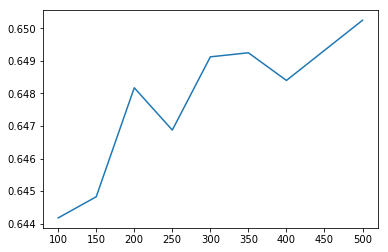

In [10]:
# This serves to find the optimal number of trees before diminishing return of Random Forest kicks in
# I will then use this optimal number of trees to do GridSearch
X = first_adv_feature_mat.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nums_trees = [100, 150, 200, 250, 300, 350, 400, 450, 500]
plot.random_forest_plotting(nums_trees, X_train, y_train)

In [13]:
rf = RandomForestClassifier(n_estimators=300, criterion='entropy', n_jobs=-1)
rf_params = {'max_depth': [600, 500, 400, 300, 200, 150, 120, 100, 80, 60, 40],
             'max_features': [None, 0.9, 0.8]}
gdb = GradientBoostingClassifier(max_features=None)
gdb_params = {'n_estimators': [300, 200, 150, 100, 50],
              'learning_rate': [0.05, 0.1, 0.5, 1.0],
              'max_depth': [4, 6, 8],
              'max_features': [None, 0.9, 0.8]}
lr = LogisticRegression()
lr_params = {'penalty': ['l1', 'l2'],
             'C': [1, 2, 5, 10, 20, 50, 100]}
estimators = [rf, gdb, lr]
params = [rf_params, gdb_params, lr_params]

In [ ]:
best_estimators = []
for estimator, param_grid in zip(estimators, params):
    gridsearch = GridSearchCV(estimator, param_grid, n_jobs=-1, verbose=2, scoring='accuracy', cv=8)
    gridsearch.fit(X_train, y_train)
    print 'best params for {} is: {}'.format(estimator.__class__.__name__, gridsearch.best_params_)
    best_estimators.append(gridsearch.best_estimator_)

Turns out that Random Forest and Gradient Boosting are still failing to offer any boost to prediction accuracy with all the hyperparameter tuning. Therefore, I would stick with Logistic Regression Model as my final model.

### Accuracy over time
Although I strived to make my model more accurate and failed, a near 70% accuracy at only the 10-minute mark still bothers me as rather imbalanced. So I decided to look into it more by varying the time mark at which I gather net_gold information within the first 10 minutes. I would retrain my model every time I do that, and check how my model's accuracy varies over time.

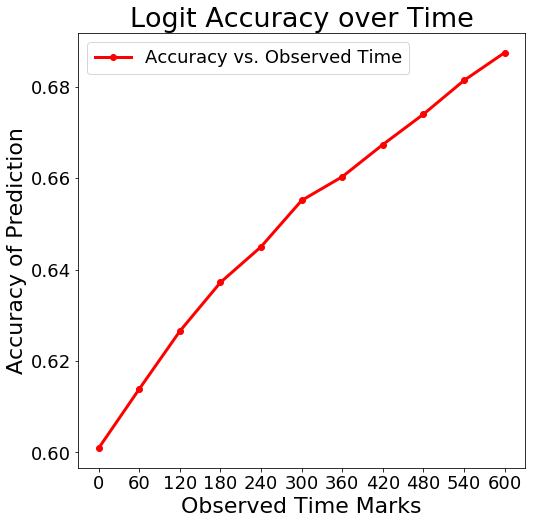

In [13]:
plot.plot_accuracy_vs_time(players_time_df, hero_selection_df, y)

This is good news, because my accuracy of prediction is increasing linearly over time. This means that there are no point in time within the first 10 minutes that offers significant insight into how the game will play out. In plain English, early game does not decide the outcome of the game. This is a good sign because the game is rather balanced with respect to time.